# Bay Area Boba EDA

**Question:** What patterns in location and pricing relate to higher ratings?

In [7]:
# Set project root + imports
import sys
from pathlib import Path

# When running notebooks/eda.ipynb, project root is one level up
ROOT = Path.cwd().parent  # -> .../boba-eda-starter
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

# Local imports
from src.clean import clean_pipeline
from src.viz import savefig
import matplotlib.pyplot as plt
import numpy as np


# Data load
DATA_PATH = ROOT / "data" / "bayarea_boba_spots.csv"  # Absolute path from ROOT
df = clean_pipeline(DATA_PATH)
df.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,id,name,rating,address,city,lat,lon
0,99-tea-house-fremont-2,99% Tea House,4.5,3623 Thornton Ave,Fremont,37.562950,-122.010040
1,one-tea-fremont-2,One Tea,4.5,46809 Warm Springs Blvd,Fremont,37.489067,-121.929414
2,royaltea-usa-fremont,Royaltea USA,4.0,38509 Fremont Blvd,Fremont,37.551315,-121.993850
3,teco-tea-and-coffee-bar-fremont,TECO Tea & Coffee Bar,4.5,39030 Paseo Padre Pkwy,Fremont,37.553694,-121.981043
4,t-lab-fremont-3,T-LAB,4.0,34133 Fremont Blvd,Fremont,37.576149,-122.043705


## Data Dictionary & Assumptions
- `rating`: Yelp star rating (0–5)
- `lat`/`lon`: WGS84 degrees
- `city`: parsed from address; trimmed of whitespace
- Assumptions: ratings are subjective/noisy; no price column in base CSV (add if available).

## Top Cities by Number of Shops

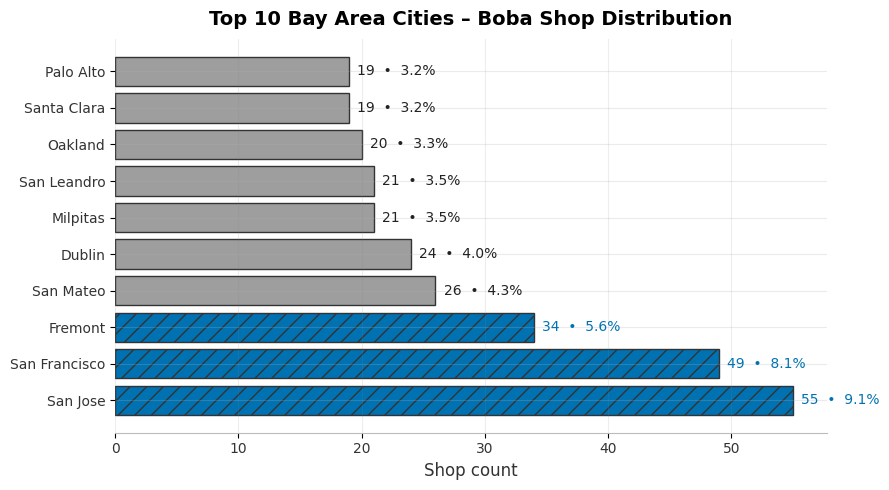

In [27]:
# --- Data prep ---
city_counts = (
    df.groupby("city", as_index=False)
      .size()
      .sort_values("size", ascending=False)
      .head(10)
      .reset_index(drop=True)
)
total_shops = int(df.shape[0])
city_counts["share"] = city_counts["size"] / total_shops

# --- Colors (Okabe–Ito palette for CVD safety) ---
base_color   = "#9E9E9E"   # Neutral gray
accent_color = "#0072B2"   # Blue for top 3
colors = [accent_color if i < 3 else base_color for i in range(len(city_counts))]
hatches = ['//' if i < 3 else '' for i in range(len(city_counts))]  # non-color cue

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 5), facecolor="white")
bars = ax.barh(city_counts["city"], city_counts["size"], 
               color=colors, edgecolor="#333")

# Apply hatching for top 3
for b, h in zip(bars, hatches):
    if h:
        b.set_hatch(h)

# Title
ax.set_title("Top 10 Bay Area Cities – Boba Shop Distribution",
             fontsize=14, weight="bold", pad=10)

ax.set_xlabel("Shop count", fontsize=12, color="#333")
ax.set_ylabel("")

# Data labels with top 3 in blue
xpad = max(city_counts["size"]) * 0.012
for i, (cnt, share) in enumerate(zip(city_counts["size"], city_counts["share"])):
    label_color = accent_color if i < 3 else "#222"
    ax.text(cnt + xpad, i, f"{cnt}  •  {share:.1%}",
            va="center", fontsize=10, color=label_color)

# Minimal, accessible styling
ax.grid(axis="x", alpha=0.15, color="#888", linewidth=0.8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bbb")
ax.tick_params(labelcolor="#333")

plt.tight_layout()
plt.savefig(ROOT / "assets" / "top_cities.png", dpi=300)
plt.show()

**Takeaway:** San Jose and San Francisco together account for ~31% of all Bay Area boba shops,
representing two distinct gravity centers: South Bay scale and SF’s dense urban market.

Fremont emerges as an East Bay demand cluster—driven more by stable suburban consumption 
(commuters + families) than transient tourist traffic.

Mid-tier cities (Dublin, Milpitas, San Leandro, Santa Clara, Palo Alto) form a long tail—
sufficient supply to validate demand, yet not saturated, making them viable testbeds for 
smaller-format or niche operators.